[INFO] [cuML] ➜ no disponible
[INFO] Usando dispositivo: cuda
[INFO] Cargando tensor global desde: /home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz


¿GPU visible?: True
torch.cuda.is_available -> True
torch.version.cuda      -> 12.1
cupy GPU visible        -> True
¿GPU visible?: True
✅ Argumentos del experimento cargados.
Cargando datos crudos...


[INFO] Tensor global cargado. Forma: (431, 7, 131, 131)
[INFO] Cargando metadatos desde: /home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado.csv
[INFO] Metadatos cargados. Forma: (434, 33)


Datos cargados.

Recalculando predicciones de los pliegues de prueba...
✅ Predicciones recolectadas (usando 514 features para compatibilidad).
Realizando análisis de bootstrap (puede tardar un momento)...
✅ Análisis de bootstrap completado.


[INFO] maxp pruned
[INFO] cmap pruned
[INFO] kern dropped
[INFO] post pruned
[INFO] FFTM dropped
[INFO] GPOS pruned
[INFO] GSUB pruned
[INFO] name pruned
[INFO] glyf pruned
[INFO] Added gid0 to subset
[INFO] Added first four glyphs to subset
[INFO] Closing glyph list over 'GSUB': 6 glyphs before
[INFO] Glyph names: ['.notdef', '.null', 'A', 'B', 'nonmarkingreturn', 'space']
[INFO] Glyph IDs:   [0, 1, 2, 3, 36, 37]
[INFO] Closed glyph list over 'GSUB': 6 glyphs after
[INFO] Glyph names: ['.notdef', '.null', 'A', 'B', 'nonmarkingreturn', 'space']
[INFO] Glyph IDs:   [0, 1, 2, 3, 36, 37]
[INFO] Closing glyph list over 'glyf': 6 glyphs before
[INFO] Glyph names: ['.notdef', '.null', 'A', 'B', 'nonmarkingreturn', 'space']
[INFO] Glyph IDs:   [0, 1, 2, 3, 36, 37]
[INFO] Closed glyph list over 'glyf': 6 glyphs after
[INFO] Glyph names: ['.notdef', '.null', 'A', 'B', 'nonmarkingreturn', 'space']
[INFO] Glyph IDs:   [0, 1, 2, 3, 36, 37]
[INFO] Retaining 6 glyphs
[INFO] head subsetting not neede

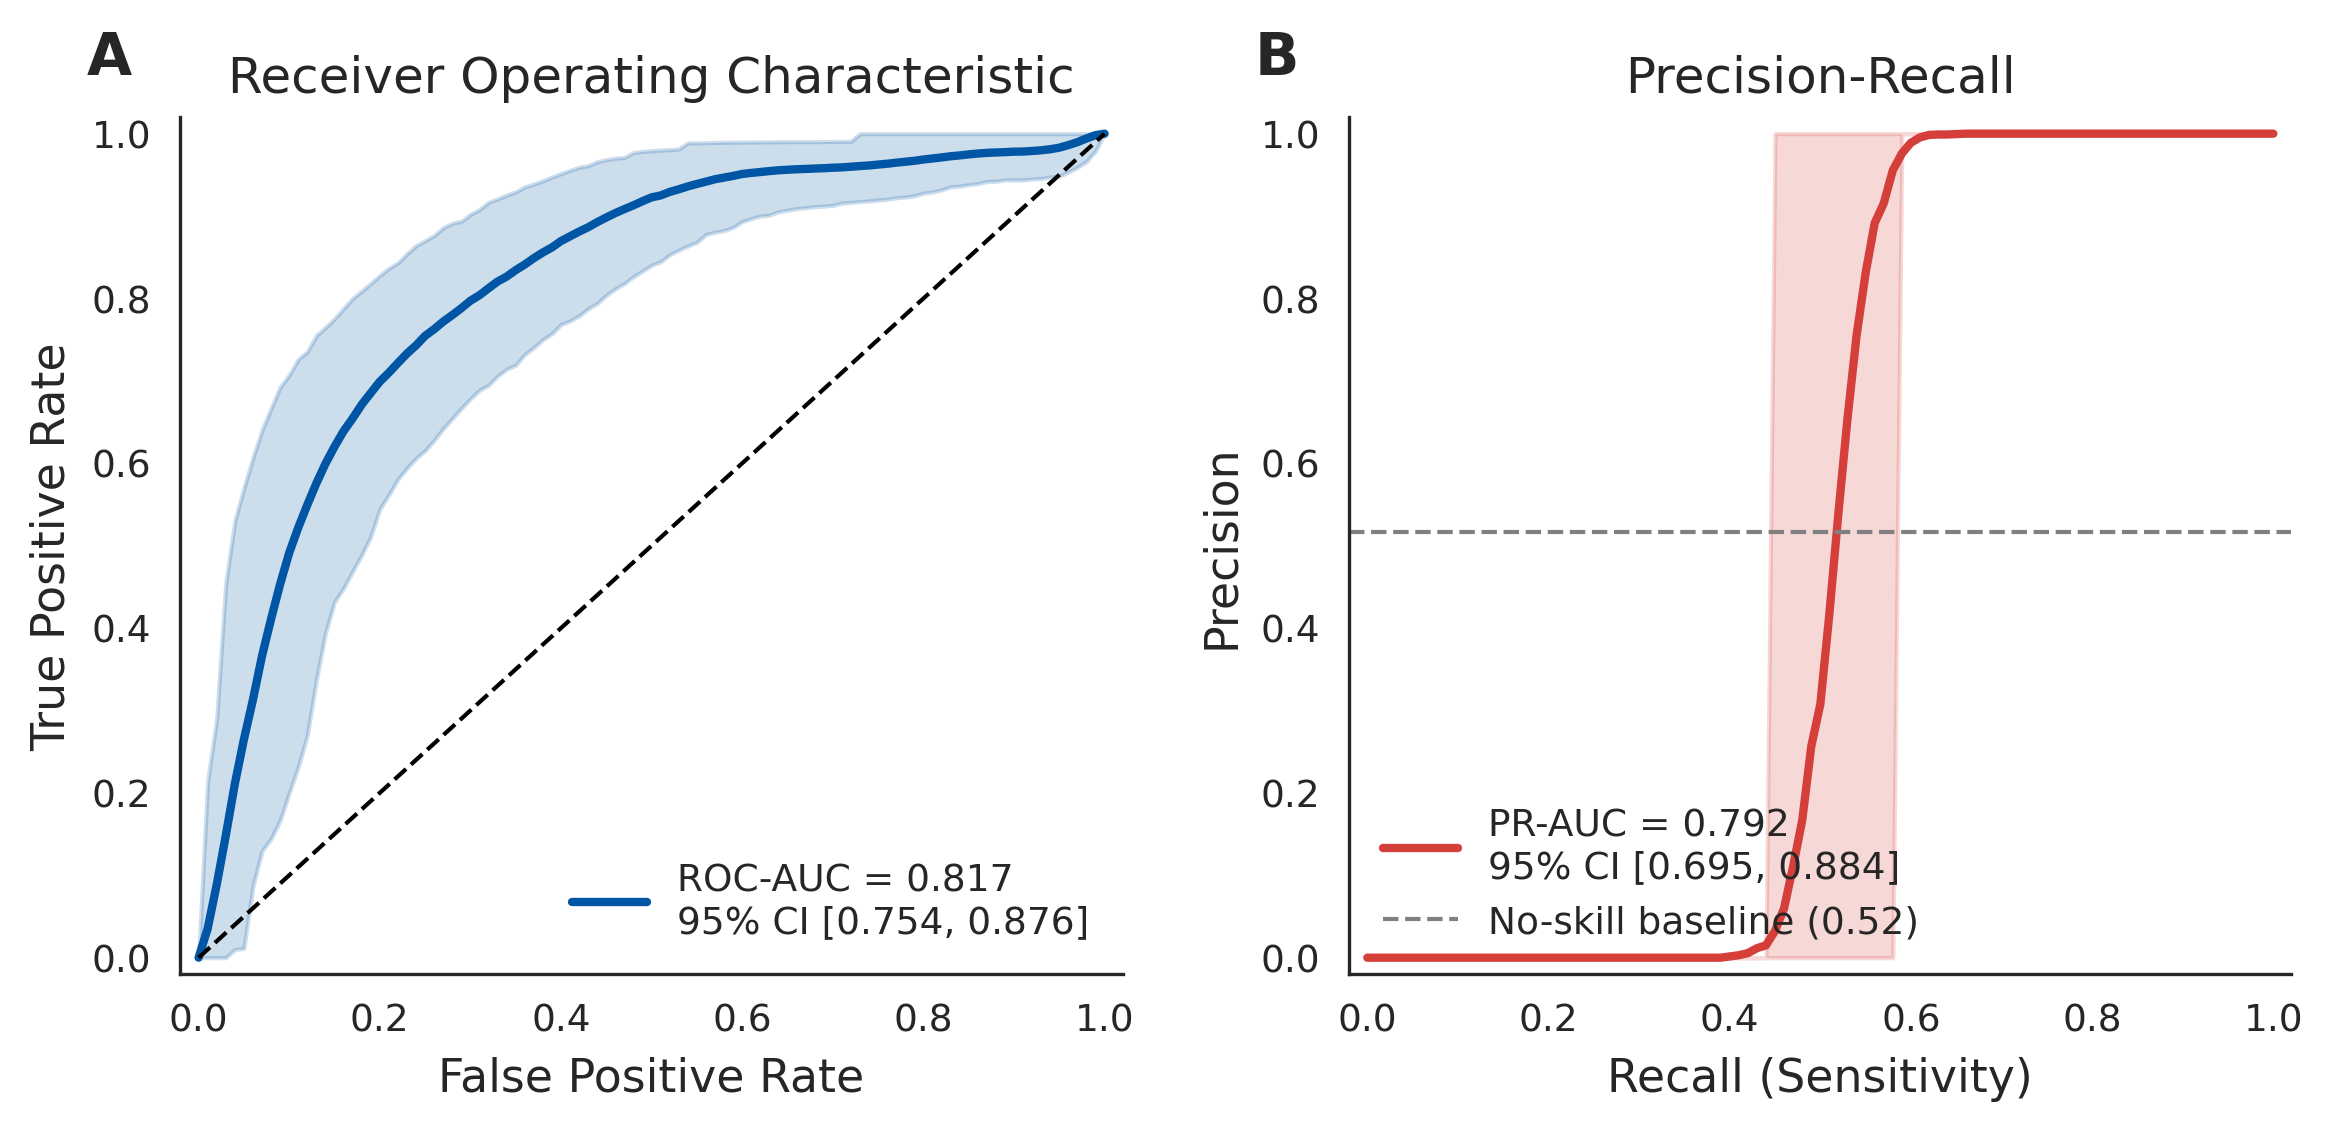


🎉 ¡Figura mejorada guardada en formatos PDF, PNG y SVG en: resultados_13_paper/publication_figures/figure_performance_curves_publication!


In [1]:
import joblib
import numpy as np
import pandas as pd
import torch
import re
import ast
from pathlib import Path
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, brier_score_loss, roc_auc_score, average_precision_score
from sklearn.calibration import calibration_curve

# --- 1. CONFIGURACIÓN Y CARGA DE DATOS ---

# Añade la ruta a tus scripts si es necesario
sys.path.append('/home/diego/Escritorio/limpio/')
from models.convolutional_vae2 import ConvolutionalVAE
from serentipia9 import load_data, apply_normalization_params

# Estilo de las figuras
plt.rc("font", family="sans-serif", size=12)
plt.rc("axes", titlesize=14, labelsize=12, titleweight='bold')
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)
plt.rc("legend", fontsize=10)
sns.set_style("whitegrid")

# Rutas
RESULTS_DIR = Path("./resultados_13_paper")
GLOBAL_TENSOR_PATH = Path("/home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz")
METADATA_CSV = Path("/home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado.csv")
OUTPUT_FIG_DIR = RESULTS_DIR / "publication_figures"
OUTPUT_FIG_DIR.mkdir(exist_ok=True)

# Cargar argumentos del experimento
try:
    summary_file = next(RESULTS_DIR.glob("summary_metrics*.txt"))
    with open(summary_file, 'r') as f:
        content = f.read()
        dict_str_match = re.search(r"\{.*\}", content, re.DOTALL)
        run_args = ast.literal_eval(dict_str_match.group(0))
    print("✅ Argumentos del experimento cargados.")
except Exception as e:
    print(f"⚠️ No se pudieron cargar los argumentos, usando fallback: {e}")
    run_args = {
        'channels_to_use': [1, 2, 5], 'latent_dim': 512, 'num_conv_layers_encoder': 4,
        'decoder_type': 'convtranspose', 'vae_final_activation': 'tanh',
        'intermediate_fc_dim_vae': 'quarter', 'dropout_rate_vae': 0.2,
        'use_layernorm_vae_fc': False,
    }

# Cargar datos crudos
print("Cargando datos crudos...")
global_tensor_data, metadata_df_full = load_data(GLOBAL_TENSOR_PATH, METADATA_CSV)
cn_ad_df = metadata_df_full[metadata_df_full['ResearchGroup_Mapped'].isin(['CN', 'AD'])].reset_index(drop=True)
print("Datos cargados.")


# ==============================================================================
# --- 2. RECOLECCIÓN DE PREDICCIONES DE TODOS LOS PLIEGUES (CORREGIDO) ---
# ==============================================================================
print("\nRecalculando predicciones de los pliegues de prueba...")
all_probs, all_trues = [], []
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for i in range(1, 6):
    fold_dir = RESULTS_DIR / f"fold_{i}"
    pipe = joblib.load(fold_dir / f"classifier_logreg_pipeline_fold_{i}.joblib")
    
    vae_model = ConvolutionalVAE(
        input_channels=len(run_args['channels_to_use']), latent_dim=run_args['latent_dim'],
        image_size=131, num_conv_layers_encoder=run_args['num_conv_layers_encoder'],
        decoder_type=run_args['decoder_type'], final_activation=run_args['vae_final_activation'],
        intermediate_fc_dim_config=run_args['intermediate_fc_dim_vae'],
        dropout_rate=run_args['dropout_rate_vae'], use_layernorm_fc=run_args['use_layernorm_vae_fc']
    ).to(device)
    
    vae_model.load_state_dict(torch.load(fold_dir / f"vae_model_fold_{i}.pt"))
    vae_model.eval()
    norm_params = joblib.load(fold_dir / f"vae_norm_params.joblib")

    test_indices = np.load(fold_dir / "test_indices.npy")
    test_df_fold = cn_ad_df.iloc[test_indices]
    y_true_fold = (test_df_fold.ResearchGroup_Mapped == "AD").astype(int).values

    global_indices = test_df_fold['tensor_idx'].values
    tensor_test_orig = global_tensor_data[global_indices][:, run_args['channels_to_use'], :, :]
    tensor_test_norm = apply_normalization_params(tensor_test_orig, norm_params)
    
    with torch.no_grad():
        tensor_torch = torch.from_numpy(tensor_test_norm).float().to(device)
        mu, _ = vae_model.encode(tensor_torch)
        X_latent_test = mu.cpu().numpy()

    # --- CORRECCIÓN PARA COMPATIBILIDAD CON MODELO PRE-ENTRENADO ---
    # Se debe construir el array con 514 features, como fue entrenado el pipe.
    # El manejo de 'Sex' vuelve a la versión simple (sin la columna 'sex_missing').
    metadata_test = test_df_fold[['Age', 'Sex']].copy()
    metadata_test['Sex'] = metadata_test['Sex'].map({'M': 0, 'F': 1}).fillna(0) # Rellena NaNs para mantener las 2 columnas
    
    # Combinar para obtener 512 (latente) + 2 (metadata) = 514 features
    X_test_combined = np.hstack([X_latent_test, metadata_test.values])
    
    # Ahora X_test_combined tiene la forma correcta (n_samples, 514)
    y_prob_fold = pipe.predict_proba(X_test_combined)[:, 1]
    
    all_probs.append(y_prob_fold)
    all_trues.append(y_true_fold)

y_prob = np.concatenate(all_probs)
y_true = np.concatenate(all_trues)
print("✅ Predicciones recolectadas (usando 514 features para compatibilidad).")

# ==============================================================================
# --- 3. ANÁLISIS DE BOOTSTRAP Y VISUALIZACIÓN (VERSIÓN MEJORADA) ---
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (roc_curve, precision_recall_curve,
                             roc_auc_score, average_precision_score)
from pathlib import Path
print("Realizando análisis de bootstrap (puede tardar un momento)...")
rng = np.random.default_rng(42)
B = 2000  # Número de remuestreos

# --- Lógica de Bootstrap para ROC y PR (se mantiene tu código original) ---
# --- Bootstrap para la curva ROC ---
fpr_grid = np.linspace(0, 1, 101)
tprs, aucs_roc = [], []
for _ in range(B):
    idx = rng.integers(0, len(y_true), len(y_true))
    if len(np.unique(y_true[idx])) < 2: continue
    fpr_i, tpr_i, _ = roc_curve(y_true[idx], y_prob[idx])
    tpr_interp = np.interp(fpr_grid, fpr_i, tpr_i)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)
    aucs_roc.append(roc_auc_score(y_true[idx], y_prob[idx]))

tprs = np.array(tprs)
tpr_mean = tprs.mean(0)
tpr_low = np.percentile(tprs, 2.5, 0)
tpr_high = np.percentile(tprs, 97.5, 0)
auc_roc_low, auc_roc_high = np.percentile(aucs_roc, [2.5, 97.5])

# --- Bootstrap para la curva PR ---
recall_grid = np.linspace(0, 1, 101)
precs, aucs_pr = [], []
for _ in range(B):
    idx = rng.integers(0, len(y_true), len(y_true))
    if len(np.unique(y_true[idx])) < 2: continue
    r, p, _ = precision_recall_curve(y_true[idx], y_prob[idx])
    p_interp = np.interp(recall_grid, r[::-1], p[::-1])
    precs.append(p_interp)
    aucs_pr.append(average_precision_score(y_true[idx], y_prob[idx]))

precs = np.array(precs)
prec_mean = precs.mean(0)
prec_low = np.percentile(precs, 2.5, 0)
prec_high = np.percentile(precs, 97.5, 0)
auc_pr_low, auc_pr_high = np.percentile(aucs_pr, [2.5, 97.5])

print("✅ Análisis de bootstrap completado.")

# ==============================================================================
# --- Creación de la figura final con estilo de publicación ---
# ==============================================================================

# 1. Definir estilo y colores
plt.style.use('default') # Reset a un estilo base
sns.set_style("white") # Fondo blanco sin grilla por defecto

import matplotlib as mpl

# Parámetros para un look profesional (calidad de revista)
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"], # Fuentes limpias
    "font.size": 10,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "figure.dpi": 300,
    "axes.spines.top": False, # Eliminar bordes superior y derecho
    "axes.spines.right": False,
    "pdf.fonttype": 42, # Embeber fuentes en PDF como TrueType
    "ps.fonttype": 42
})

# Paleta de colores profesional
COLOR_ROC = '#0055A4' # Azul Francia
COLOR_PR  = '#D43F3A' # Rojo Ladrillo

# 2. Creación de la figura
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4)) # Un poco más compacto

# --- Panel A: Curva ROC ---
roc_label = (f'ROC-AUC = {np.mean(aucs_roc):.3f}\n'
             f'95% CI [{auc_roc_low:.3f}, {auc_roc_high:.3f}]')
ax1.plot(fpr_grid, tpr_mean, color=COLOR_ROC, lw=2, label=roc_label)
ax1.fill_between(fpr_grid, tpr_low, tpr_high, color=COLOR_ROC, alpha=0.2)
ax1.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
ax1.set(xlim=[-0.02, 1.02], ylim=[-0.02, 1.02],
        xlabel='False Positive Rate', ylabel='True Positive Rate',
        title='Receiver Operating Characteristic')
ax1.legend(loc="lower right", frameon=False)
ax1.text(-0.1, 1.05, 'A', transform=ax1.transAxes, fontsize=14, fontweight='bold')


# --- Panel B: Curva PR ---
baseline = y_true.mean()
pr_label = (f'PR-AUC = {np.mean(aucs_pr):.3f}\n'
            f'95% CI [{auc_pr_low:.3f}, {auc_pr_high:.3f}]')
ax2.plot(recall_grid, prec_mean, color=COLOR_PR, lw=2, label=pr_label)
ax2.fill_between(recall_grid, prec_low, prec_high, color=COLOR_PR, alpha=0.2)
ax2.axhline(baseline, color='grey', linestyle='--', lw=1, label=f'No-skill baseline ({baseline:.2f})')
ax2.set(xlim=[-0.02, 1.02], ylim=[-0.02, 1.02],
        xlabel='Recall (Sensitivity)', ylabel='Precision',
        title='Precision-Recall')
ax2.legend(loc="lower left", frameon=False)
ax2.text(-0.1, 1.05, 'B', transform=ax2.transAxes, fontsize=14, fontweight='bold')

# 3. Guardar en múltiples formatos (vectorial y raster) y mostrar
fig.tight_layout(pad=1.5)
fig_path_base = OUTPUT_FIG_DIR / "figure_performance_curves_publication"

# Guardar en los formatos que ya tenías
plt.savefig(f"{fig_path_base}.pdf", bbox_inches='tight')
plt.savefig(f"{fig_path_base}.png", dpi=300, bbox_inches='tight')

# --- LÍNEA NUEVA AÑADIDA ---
# Guardar en formato SVG
plt.savefig(f"{fig_path_base}.svg", bbox_inches='tight')

plt.show()

print(f"\n🎉 ¡Figura mejorada guardada en formatos PDF, PNG y SVG en: {fig_path_base}!")

[INFO] Cargando tensor global desde: /home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz


✅ Archivos encontrados para el experimento:
    xgb_vaeconvtranspose4l_ld512_beta4.6_normzscore_offdiag_ch3sel_intFCquarter_drop0.2_ln0_outer5x1_scoreroc_auc
🏆 Mejor clasificador identificado: 'logreg' (basado en 'auc' promedio)

Cargando tensor y metadatos para análisis UMAP...


[INFO] Tensor global cargado. Forma: (431, 7, 131, 131)
[INFO] Cargando metadatos desde: /home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado.csv
[INFO] Metadatos cargados. Forma: (434, 33)


Datos crudos cargados exitosamente.


[INFO] maxp pruned
[INFO] cmap pruned
[INFO] kern dropped
[INFO] post pruned
[INFO] FFTM dropped
[INFO] GPOS pruned
[INFO] GSUB pruned
[INFO] name pruned
[INFO] glyf pruned
[INFO] Added gid0 to subset
[INFO] Added first four glyphs to subset
[INFO] Closing glyph list over 'GSUB': 27 glyphs before
[INFO] Glyph names: ['.notdef', '.null', 'A', 'E', 'F', 'L', 'T', 'V', 'a', 'd', 'e', 'five', 'four', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'two']
[INFO] Glyph IDs:   [0, 1, 2, 3, 20, 21, 22, 23, 24, 36, 40, 41, 47, 55, 57, 68, 71, 72, 74, 76, 79, 81, 82, 83, 85, 86, 87]
[INFO] Closed glyph list over 'GSUB': 27 glyphs after
[INFO] Glyph names: ['.notdef', '.null', 'A', 'E', 'F', 'L', 'T', 'V', 'a', 'd', 'e', 'five', 'four', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'two']
[INFO] Glyph IDs:   [0, 1, 2, 3, 20, 21, 22, 23, 24, 36, 40, 41, 47, 55, 57, 68, 71, 72, 74, 76, 79, 81, 82, 83, 85, 86, 87]


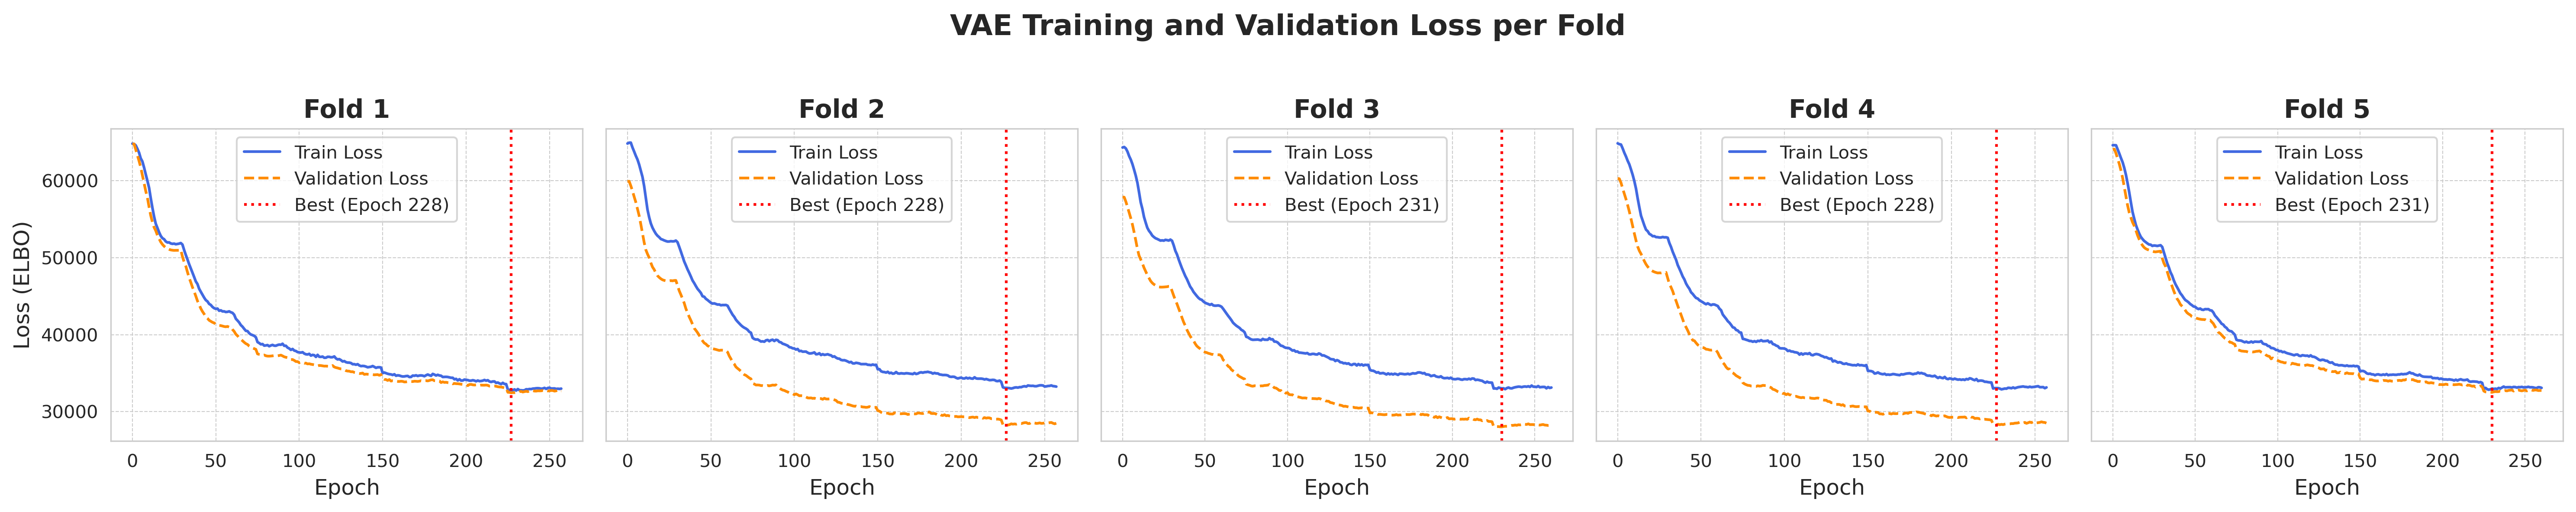

🖼️  Figura de entrenamiento del VAE guardada en: resultados_13_paper/publication_figures


In [2]:
# ===================================================================
# --- 1. SETUP, IMPORTS Y CARGA DE DATOS ---
# ===================================================================
import joblib
import json
import glob
import re
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import seaborn as sns
import torch
from pathlib import Path
import umap # Asegúrate de tenerlo instalado: pip install umap-learn
import ast # Para evaluar strings de forma segura

# --- Importaciones de tu código (asegúrate de que los .py estén accesibles) ---
import sys
# ¡IMPORTANTE! Ajusta esta ruta a la ubicación de tus scripts si es necesario
sys.path.append('/home/diego/Escritorio/limpio/')
from models.convolutional_vae2 import ConvolutionalVAE
# BUG CORREGIDO: Necesitamos importar estas funciones para la sección de UMAP
from serentipia9 import load_data, apply_normalization_params

# --- Estilo de Figuras para Publicación (estilo Nature) ---
plt.rc("font", family="sans-serif", size=12)
plt.rc("axes", titlesize=14, labelsize=12, titleweight='bold')
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)
plt.rc("legend", fontsize=10)
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

# --- Rutas a los Artefactos del Experimento ---
RESULTS_DIR = Path("./resultados_13_paper")
GLOBAL_TENSOR_PATH = Path("/home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz")
METADATA_CSV = Path("/home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado.csv")
OUTPUT_FIG_DIR = RESULTS_DIR / "publication_figures"
OUTPUT_FIG_DIR.mkdir(exist_ok=True)

# --- Carga de Datos y Artefactos ---
try:
    # Búsqueda robusta de los archivos de resultados
    csv_files = list(RESULTS_DIR.glob("all_folds_metrics_MULTI_*.csv"))
    if not csv_files:
        raise FileNotFoundError("No se encontró el archivo de métricas CSV.")
    CSV_PATH = csv_files[0]
    
    # Extraer el sufijo del nombre del archivo para encontrar los demás
    match = re.search(r"all_folds_metrics_MULTI_(.*)\.csv", CSV_PATH.name)
    if not match:
        raise ValueError("No se pudo extraer el sufijo del experimento del nombre del archivo.")
    SUFFIX = match.group(1)

    HIST_PATH = RESULTS_DIR / f"all_folds_vae_training_history_{SUFFIX}.joblib"
    
    print(f"✅ Archivos encontrados para el experimento:\n    {SUFFIX}")

    # Carga de Datos
    metrics_df = pd.read_csv(CSV_PATH)
    histories = joblib.load(HIST_PATH)
    
    # Determinar el mejor clasificador basado en la métrica de scoring (roc_auc)
    best_clf_name = metrics_df.groupby('actual_classifier_type')['auc'].mean().idxmax()
    print(f"🏆 Mejor clasificador identificado: '{best_clf_name}' (basado en 'auc' promedio)")

except (FileNotFoundError, IndexError, ValueError) as e:
    print(f"❌ ERROR: {e}. Asegúrate de que la ruta '{RESULTS_DIR}' es correcta y el pipeline ha finalizado.")
    metrics_df, histories, best_clf_name = None, None, None

# Carga de datos crudos para UMAP
if metrics_df is not None:
    print("\nCargando tensor y metadatos para análisis UMAP...")
    global_tensor_data, metadata_df_full = load_data(GLOBAL_TENSOR_PATH, METADATA_CSV)
    print("Datos crudos cargados exitosamente.")

# ===================================================================
# --- 2. Figura 1: Curvas de Entrenamiento del VAE ---
# ===================================================================
if histories:
    fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)
    fig.suptitle("VAE Training and Validation Loss per Fold", fontsize=16, weight='bold')

    for i, history in enumerate(histories):
        ax = axes[i]
        ax.plot(history["train_loss"], label="Train Loss", color='royalblue')
        if "val_loss" in history and any(not np.isnan(x) for x in history["val_loss"]):
            ax.plot(history["val_loss"], label="Validation Loss", color='darkorange', linestyle='--')
        
        best_epoch = np.nanargmin(history['val_loss']) if 'val_loss' in history and any(not np.isnan(x) for x in history["val_loss"]) else -1
        if best_epoch != -1:
            ax.axvline(best_epoch, color='red', linestyle=':', lw=1.5, label=f'Best (Epoch {best_epoch+1})')

        ax.set_title(f"Fold {i+1}")
        ax.set_xlabel("Epoch")
        if i == 0:
            ax.set_ylabel("Loss (ELBO)")
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    fig.savefig(OUTPUT_FIG_DIR / "figure1_vae_training_curves.png", dpi=300, bbox_inches='tight')
    fig.savefig(OUTPUT_FIG_DIR / "figure1_vae_training_curves.pdf", bbox_inches='tight')
    plt.show()
    print(f"🖼️  Figura de entrenamiento del VAE guardada en: {OUTPUT_FIG_DIR}")




--- Generando embeddings latentes de los datos de TEST de cada fold ---
✅ Argumentos cargados: Canales=[1, 2, 5], Dim Latente=512
✅ Embeddings de test generados para todos los folds.


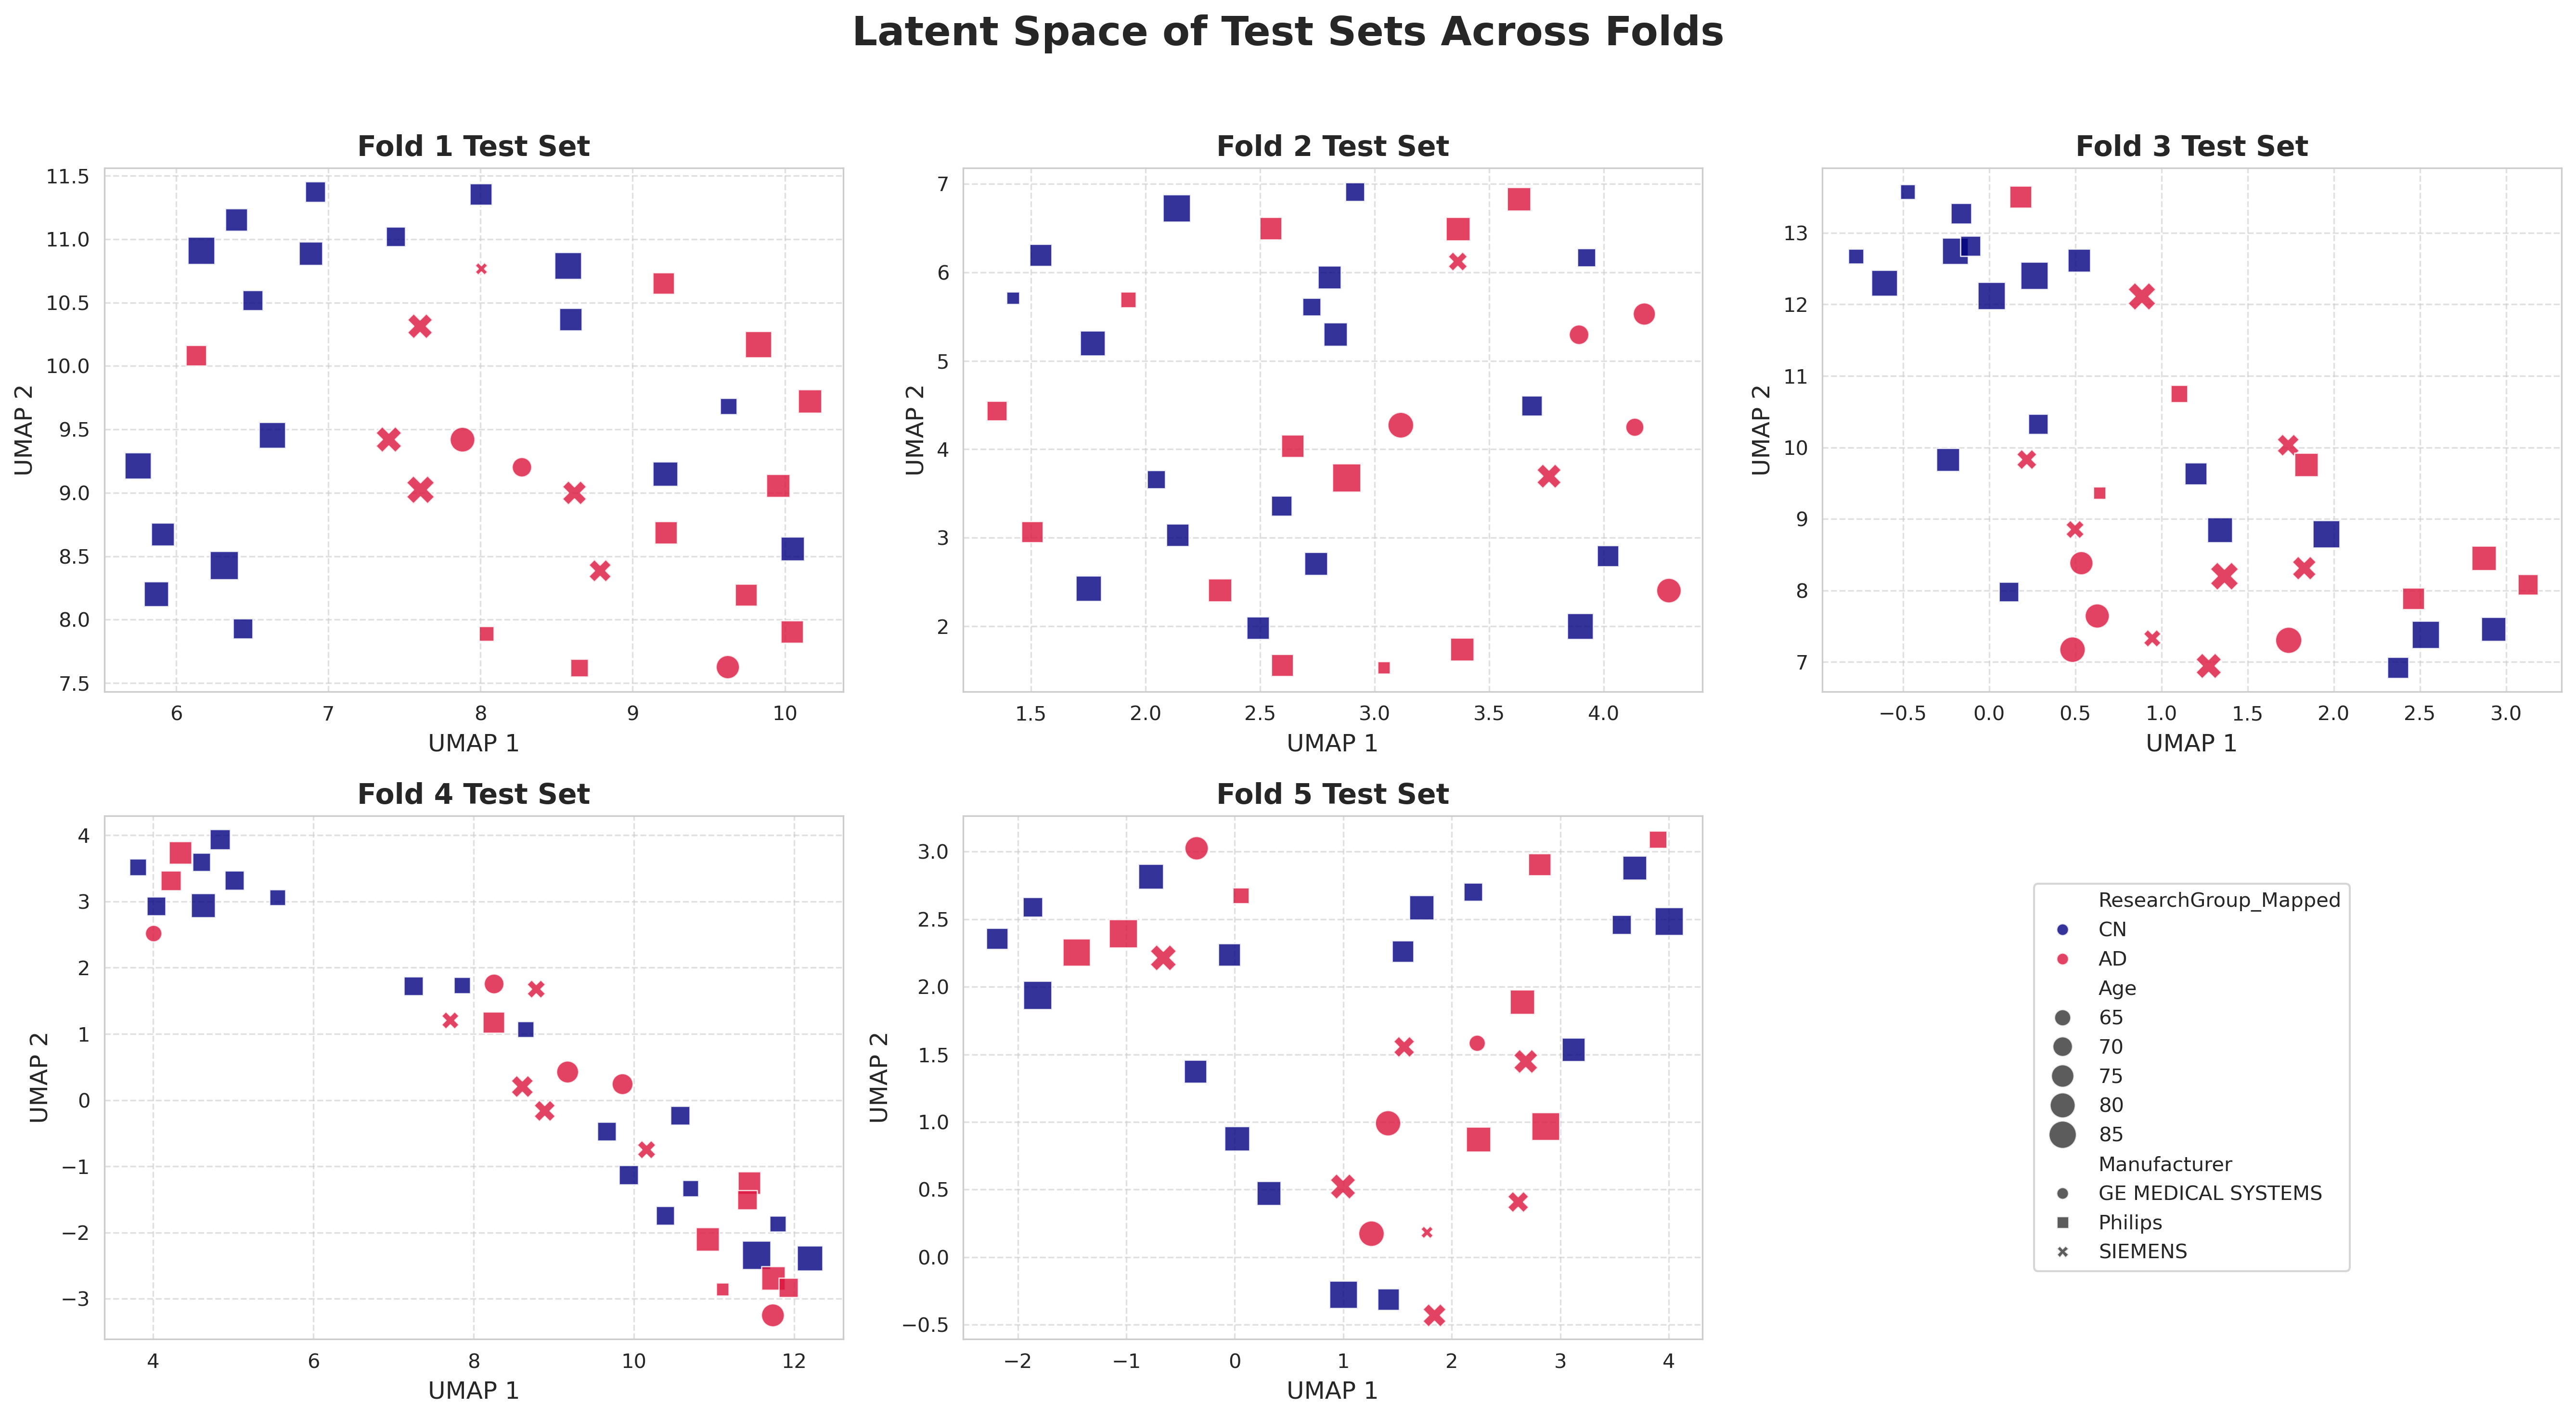

In [3]:
# ==============================================================================
# --- 3. Figura 2: Análisis del Espacio Latente por Fold (CORREGIDO) ---
# ==============================================================================
import logging
import umap

# AJUSTE: Silenciar logs ruidosos al guardar figuras
logging.getLogger('fontTools.subset').setLevel(logging.ERROR)

if 'metrics_df' in locals() and metrics_df is not None and 'global_tensor_data' in locals():
    print("\n--- Generando embeddings latentes de los datos de TEST de cada fold ---")

    # Carga de argumentos y generación de embeddings (Versión Limpia, sin duplicados)
    try:
        summary_files = list(RESULTS_DIR.glob("summary_metrics*.txt"))
        with open(summary_files[0], 'r') as f:
            run_args = ast.literal_eval(re.search(r"\{.*\}", f.read(), re.DOTALL).group(0))
        print(f"✅ Argumentos cargados: Canales={run_args.get('channels_to_use')}, Dim Latente={run_args.get('latent_dim')}")
    except Exception as e:
        print(f"⚠️ No se pudo cargar 'run_args' ({e}). Usando configuración de fallback.")
        run_args = {'channels_to_use':[1,2,5],'latent_dim':512,'num_conv_layers_encoder':4,
                    'decoder_type':'convtranspose','vae_final_activation':'tanh',
                    'intermediate_fc_dim_vae':'quarter','dropout_rate_vae':0.2,
                    'use_layernorm_vae_fc':False}

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    all_fold_data = []
    cn_ad_df = metadata_df_full[metadata_df_full['ResearchGroup_Mapped'].isin(['CN','AD'])].reset_index(drop=True)

    for i in range(1, 6):
        fold_dir = RESULTS_DIR / f"fold_{i}"
        vae = ConvolutionalVAE(
            input_channels=len(run_args['channels_to_use']), latent_dim=run_args['latent_dim'], image_size=131,
            num_conv_layers_encoder=run_args['num_conv_layers_encoder'], decoder_type=run_args['decoder_type'],
            final_activation=run_args['vae_final_activation'], intermediate_fc_dim_config=run_args['intermediate_fc_dim_vae'],
            dropout_rate=run_args['dropout_rate_vae'], use_layernorm_fc=run_args['use_layernorm_vae_fc']
        ).to(device)
        vae.load_state_dict(torch.load(fold_dir / f"vae_model_fold_{i}.pt", map_location=device))
        vae.eval()

        test_idx = np.load(fold_dir / "test_indices.npy")
        norm_params = joblib.load(fold_dir / "vae_norm_params.joblib")
        df_fold = cn_ad_df.iloc[test_idx].copy()

        tens = global_tensor_data[df_fold['tensor_idx'].values][:, run_args['channels_to_use'], :, :]
        tens = apply_normalization_params(tens, norm_params)

        with torch.no_grad():
            mu, _ = vae.encode(torch.from_numpy(tens).float().to(device))
            df_fold['embeddings'] = list(mu.cpu().numpy())
        all_fold_data.append(df_fold)
    print("✅ Embeddings de test generados para todos los folds.")

    # --- Plot UMAP por fold ---
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle("Latent Space of Test Sets Across Folds", fontsize=20, weight='bold')
    axes_flat = axes.flatten()
    
    # Se crea el diccionario de marcadores con los nombres limpios
    full_test_df = pd.concat(all_fold_data)
    full_test_df['Manufacturer'] = (full_test_df['Manufacturer']
                                    .str.replace(' Medical Systems','').str.replace(' Healthcare','')
                                    .fillna('Unknown'))
    mans = sorted(full_test_df['Manufacturer'].unique())
    markers = ["o","s","X","P","D","^","v"]
    marker_map = {m: markers[i % len(markers)] for i, m in enumerate(mans)}

    for i, df_fold in enumerate(all_fold_data):
        ax = axes_flat[i]
        reducer = umap.UMAP(n_neighbors=10, min_dist=0.2, metric='cosine', random_state=42)
        emb2d = reducer.fit_transform(np.vstack(df_fold['embeddings'].values))
        
        plot_df = pd.DataFrame(emb2d, columns=['UMAP 1','UMAP 2'])
        plot_df = pd.concat([plot_df, df_fold.reset_index(drop=True)], axis=1)

        # --- CORRECCIÓN APLICADA AQUÍ ---
        # Limpia la columna 'Manufacturer' en el DataFrame de ploteo para que coincida
        # con las claves del diccionario 'marker_map'.
        plot_df['Manufacturer'] = (plot_df['Manufacturer']
                                     .str.replace(' Medical Systems', '')
                                     .str.replace(' Healthcare', '')
                                     .fillna('Unknown'))

        sns.scatterplot(data=plot_df, x='UMAP 1', y='UMAP 2', hue='ResearchGroup_Mapped', 
                        style='Manufacturer', size='Age', palette={'CN':'navy','AD':'crimson'}, 
                        sizes=(40,200), style_order=mans, markers=marker_map, alpha=0.8, ax=ax)
        ax.set_title(f"Fold {i+1} Test Set"); ax.grid(True, linestyle='--', alpha=0.6); ax.legend().remove()

    legend_ax = axes_flat[-1]; legend_ax.axis('off')
    handles, labels = axes_flat[0].get_legend_handles_labels()
    legend_ax.legend(handles, labels, ncol=1, loc='center')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(OUTPUT_FIG_DIR / "figure2_umap_per_fold_detailed.png", dpi=300, bbox_inches='tight')
    plt.savefig(OUTPUT_FIG_DIR / "figure2_umap_per_fold_detailed.pdf", bbox_inches='tight')
    plt.show()

else:
    print("⚠️ No se ejecutó el análisis UMAP porque los datos no fueron cargados previamente.")

In [4]:
# ==============================================================================
# --- 4. QC del Espacio Latente y Exportación a LaTeX (CORREGIDO) ---
# ==============================================================================
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

def participation_ratio(evals):
    ev = np.asarray(evals, dtype=float)
    if ev.ndim != 1 or np.all(ev <= 0): return np.nan
    s1, s2 = ev.sum(), np.square(ev).sum()
    return (s1*s1)/s2 if s2 > 0 else np.nan

def clean_manufacturer(s):
    if pd.isna(s): return 'Unknown'
    return str(s).replace(' Medical Systems','').replace(' Healthcare','').strip()

assert 'all_fold_data' in globals(), "Falta all_fold_data (corré la celda de UMAP primero)."

rows = []
for fold_i, df_fold in enumerate(all_fold_data, start=1):
    Z = np.vstack(df_fold['embeddings'].values)
    y = df_fold['ResearchGroup_Mapped'].values
    site = pd.Series(df_fold['Manufacturer'].map(clean_manufacturer))

    Zstd = StandardScaler().fit_transform(Z)
    ncomp = min(20, Zstd.shape[1], max(2, Zstd.shape[0]-1))
    pca = PCA(n_components=ncomp, svd_solver="full", random_state=42)
    Zp = pca.fit_transform(Zstd)

    try: sil = silhouette_score(Zp, y, metric='euclidean')
    except Exception: sil = np.nan

    ev = pca.explained_variance_
    pr = participation_ratio(ev)
    dims90 = int(np.searchsorted(np.cumsum(pca.explained_variance_ratio_), 0.90) + 1)
    
    keep = site.map(site.value_counts()) >= 2
    acc = np.nan
    if keep.sum() >= 6 and site[keep].nunique() >= 2:
        cv = StratifiedKFold(n_splits=max(2, min(5, pd.Series(site[keep]).value_counts().min())), shuffle=True, random_state=42)
        acc = cross_val_score(KNeighborsClassifier(n_neighbors=5), Zp[keep.values], site[keep].values, cv=cv, scoring='accuracy').mean()

    rows.append({
        "Fold": fold_i, "Class Separability (Silhouette)": sil, "Confounder Effect (Site Acc.)": acc,
        "Effective Dimensions (PR)": pr, "PCA Dims (90% Var)": dims90
    })

qc_df = pd.DataFrame(rows)
qc_df.to_csv(OUTPUT_FIG_DIR / "qc_latent_space_metrics.csv", index=False)
print(f"✅ qc_df listo y guardado en: {OUTPUT_FIG_DIR / 'qc_latent_space_metrics.csv'}")

# --- AJUSTE: Exportar la tabla a formato LaTeX para el paper ---
cols = ["Class Separability (Silhouette)", "Confounder Effect (Site Acc.)", "Effective Dimensions (PR)", "PCA Dims (90% Var)"]
qc_df_round = qc_df.copy()
qc_df_round[cols[:-1]] = qc_df_round[cols[:-1]].astype(float).round(3)
qc_df_round[cols[-1]] = qc_df_round[cols[-1]].astype(int)

tex_path = OUTPUT_FIG_DIR / "table_qc_latent_space.tex"
with open(tex_path, "w") as f:
    # Formato 'ccccc' para centrar las 5 columnas en LaTeX
    f.write(qc_df_round.to_latex(index=False, escape=False, column_format="ccccc"))
print(f"📄 Tabla LaTeX guardada en: {tex_path}")

# Muestra el DataFrame original en la salida del notebook
qc_df

✅ qc_df listo y guardado en: resultados_13_paper/publication_figures/qc_latent_space_metrics.csv
📄 Tabla LaTeX guardada en: resultados_13_paper/publication_figures/table_qc_latent_space.tex


,Fold,Class Separability (Silhouette),Confounder Effect (Site Acc.),Effective Dimensions (PR),PCA Dims (90% Var)
0,1,0.048535,0.728632,9.013272,15
1,2,0.005113,0.811404,11.940155,16
2,3,0.047802,0.700000,9.011332,15
3,4,0.038308,0.778571,8.086887,15
4,5,0.010772,0.722222,10.586429,15


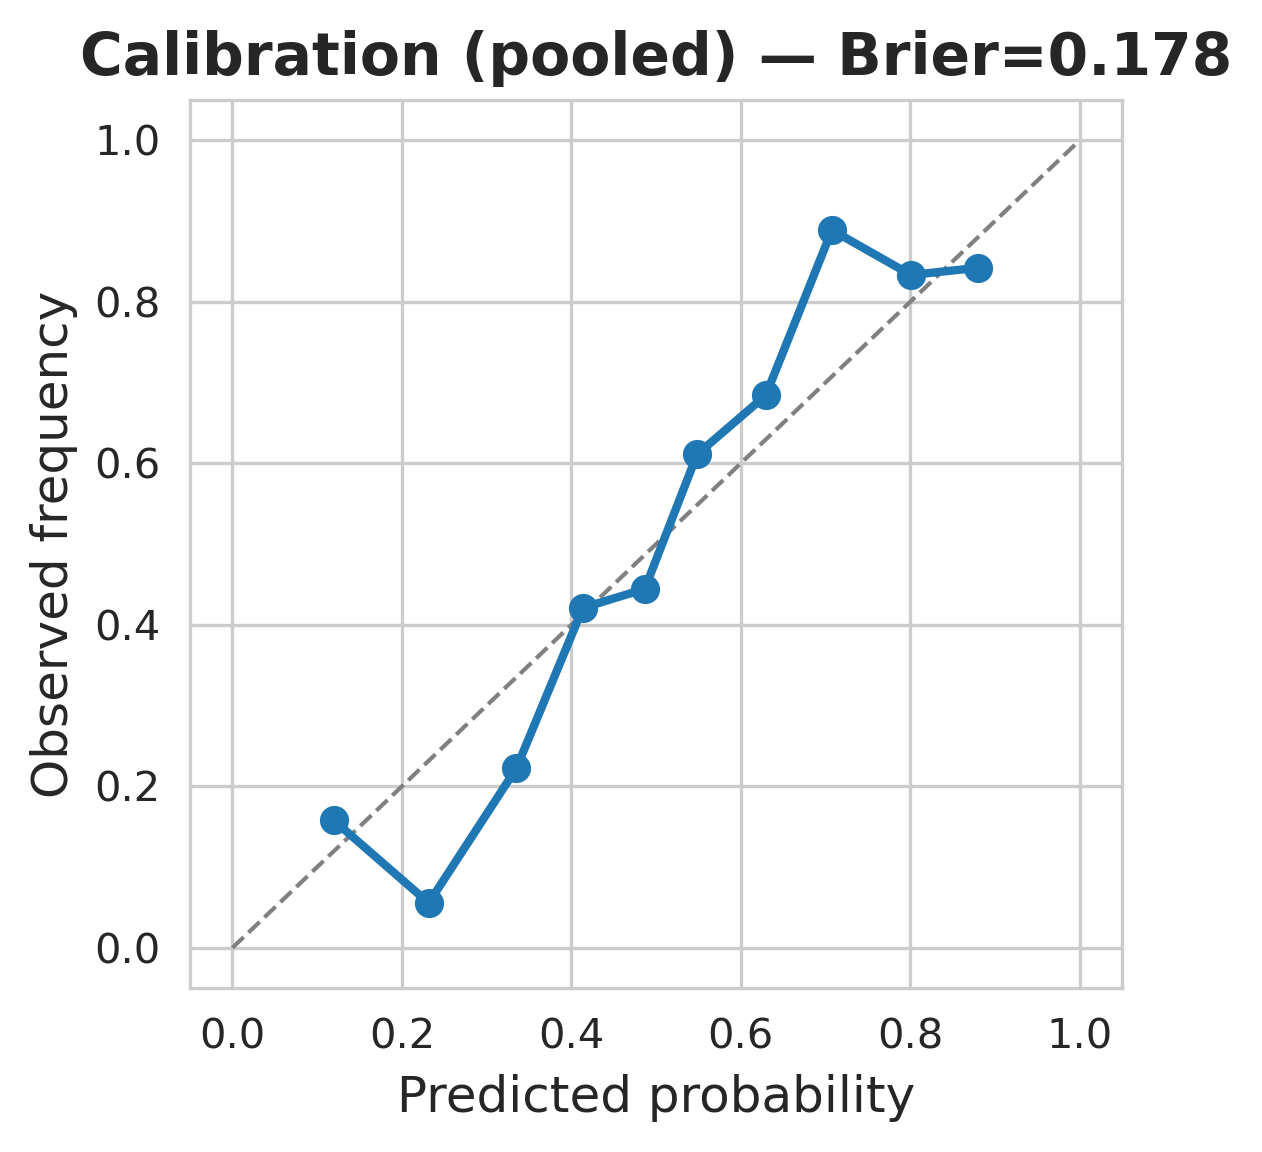

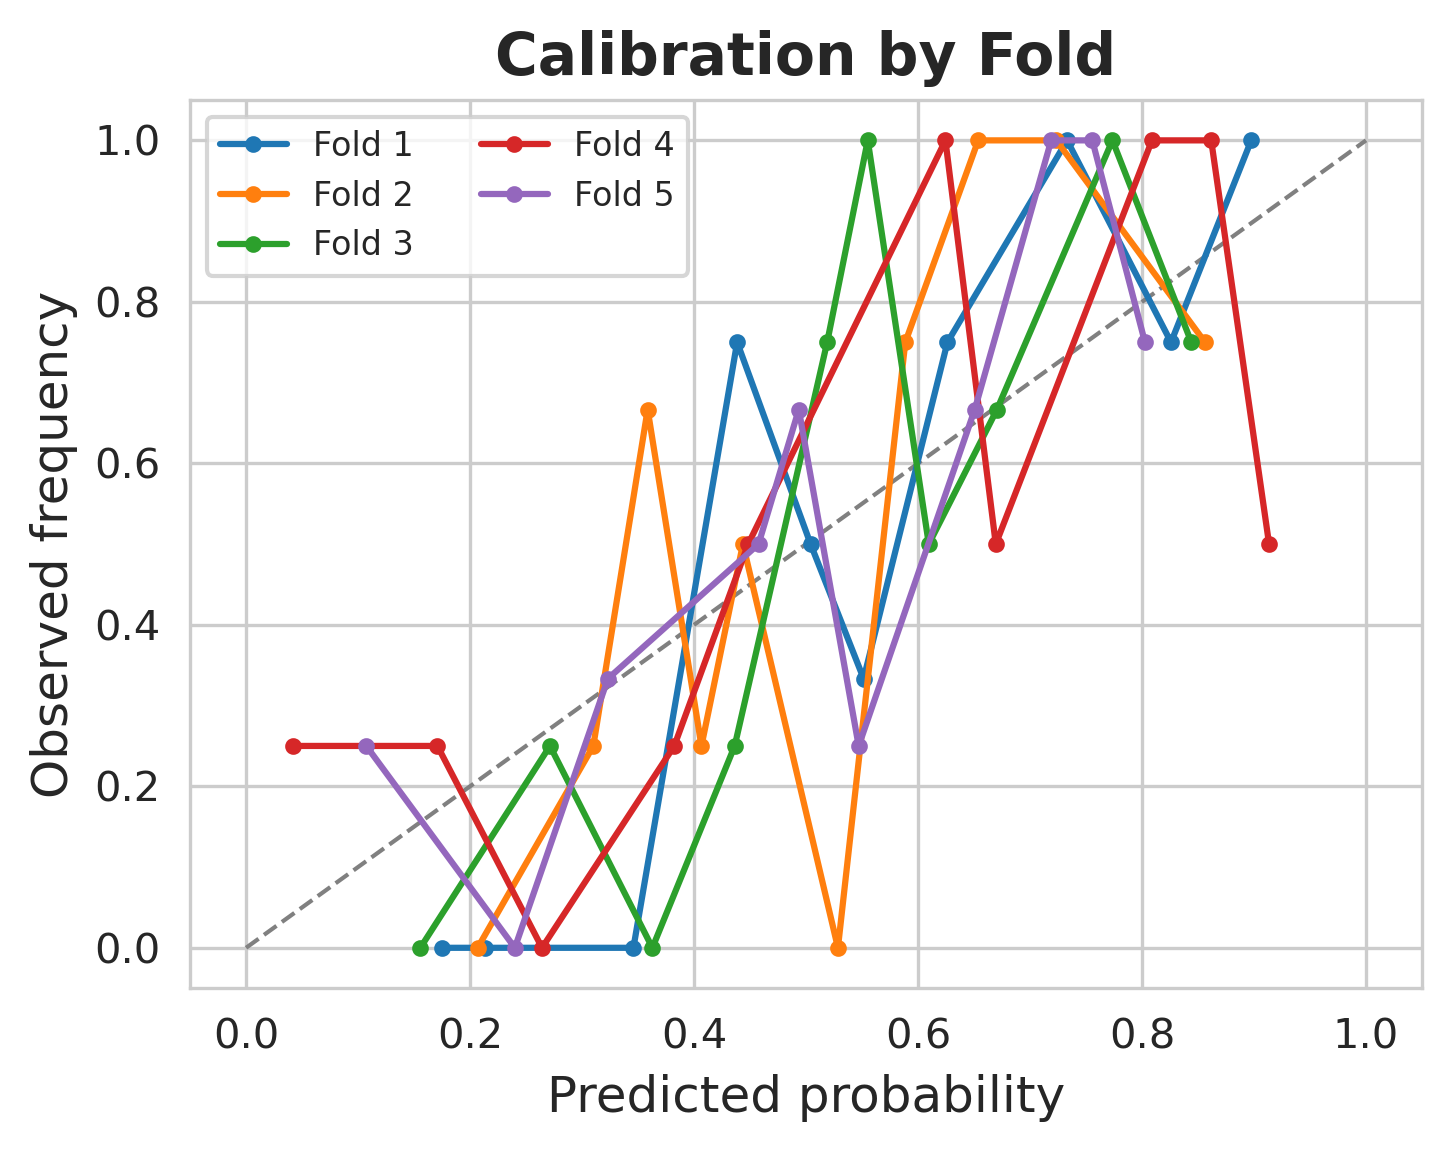

In [5]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

# Pooled
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='quantile')
brier = brier_score_loss(y_true, y_prob)

fig, ax = plt.subplots(figsize=(4,4))
ax.plot([0,1],[0,1],'--',lw=1, color='grey')
ax.plot(prob_pred, prob_true, marker='o', lw=2)
ax.set(xlabel='Predicted probability', ylabel='Observed frequency',
       title=f'Calibration (pooled) — Brier={brier:.3f}')
fig.tight_layout()
fig.savefig(OUTPUT_FIG_DIR/'figure_calibration_pooled.pdf', bbox_inches='tight')
fig.savefig(OUTPUT_FIG_DIR/'figure_calibration_pooled.png', dpi=300, bbox_inches='tight')
plt.show()

# Por fold (overlay)
fig, ax = plt.subplots(figsize=(5,4))
ax.plot([0,1],[0,1],'--',lw=1, color='grey')
for i, (p, t) in enumerate(zip(all_probs, all_trues), start=1):
    pt, pp = calibration_curve(t, p, n_bins=10, strategy='quantile')
    ax.plot(pp, pt, marker='.', lw=1.5, label=f'Fold {i}')
ax.set(xlabel='Predicted probability', ylabel='Observed frequency', title='Calibration by Fold')
ax.legend(ncol=2, fontsize=8)
fig.tight_layout()
fig.savefig(OUTPUT_FIG_DIR/'figure_calibration_by_fold.pdf', bbox_inches='tight')
fig.savefig(OUTPUT_FIG_DIR/'figure_calibration_by_fold.png', dpi=300, bbox_inches='tight')
plt.show()
